In [1]:
#Librerias usadas en la prueba
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt
from matplotlib import pyplot
import os

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from math import sqrt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Bidirectional

Using TensorFlow backend.


In [22]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#Cargar Dataset de Energia con una resolución de media hora
energy=pd.read_csv('gdrive/My Drive/Colab Notebooks/Proyecto/halfhourly_dataset/energy1.csv')


In [0]:
#energy = pd.read_csv('energy.csv')
len(energy)

169039691

In [0]:
#Dataset del consumo energetico de todas las casas que registra el dataset households Londres Dataset 7GB
energy.head()

,LCLid,tstp,energy(kWh/hh)
0,MAC000002,2012-10-12 00:30:00.0000000,0
1,MAC000002,2012-10-12 01:00:00.0000000,0
2,MAC000002,2012-10-12 01:30:00.0000000,0
3,MAC000002,2012-10-12 02:00:00.0000000,0
4,MAC000002,2012-10-12 02:30:00.0000000,0


In [0]:
energy.tail()

,LCLid,tstp,energy(kWh/hh)
169039686,MAC004828,2014-02-27 22:00:00.0000000,0
169039687,MAC004828,2014-02-27 22:30:00.0000000,0.001
169039688,MAC004828,2014-02-27 23:00:00.0000000,0.047
169039689,MAC004828,2014-02-27 23:30:00.0000000,0.008
169039690,MAC004828,2014-02-28 00:00:00.0000000,0


In [0]:
#Se selecciona la casa con que se va a realizar la prueba
CASA1=energy[['energy(kWh/hh)','tstp']][energy['LCLid']=='MAC000002']

In [0]:
len(CASA1)

48282

In [0]:
CASA1.head()

,energy(kWh/hh),tstp
0,0,2012-10-12 00:30:00.0000000
1,0,2012-10-12 01:00:00.0000000
2,0,2012-10-12 01:30:00.0000000
3,0,2012-10-12 02:00:00.0000000
4,0,2012-10-12 02:30:00.0000000


In [0]:
#Se convierte el tstp a datetime64
CASA1['tstp']=pd.to_datetime(CASA1['tstp'])

In [0]:
CASA1.head()

,energy(kWh/hh),tstp
0,0,2012-10-12 00:30:00
1,0,2012-10-12 01:00:00
2,0,2012-10-12 01:30:00
3,0,2012-10-12 02:00:00
4,0,2012-10-12 02:30:00


In [0]:
#Se establece tstp como indice
CASA1.set_index('tstp').head()

,energy(kWh/hh)
tstp,
2012-10-12 00:30:00,0
2012-10-12 01:00:00,0
2012-10-12 01:30:00,0
2012-10-12 02:00:00,0
2012-10-12 02:30:00,0


In [0]:
#clima=pd.read_csv('gdrive/My Drive/Colab Notebooks/Proyecto/halfhourly_dataset/weather_hourly_darksky.csv', parse_dates=['time'], index_col="time")

In [0]:
#Se carga el dataset de clima con resolución de una hora
clima=pd.read_csv("weather_hourly_darksky.csv", parse_dates=['time'], index_col="time")

In [0]:
clima.head()

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
time,,,,,,,,,,,
2011-11-11 00:00:00,5.97,104,10.24,8.86,1016.76,10.24,2.77,rain,partly-cloudy-night,0.91,Partly Cloudy
2011-11-11 01:00:00,4.88,99,9.76,8.83,1016.63,8.24,2.95,rain,partly-cloudy-night,0.94,Partly Cloudy
2011-11-11 02:00:00,3.70,98,9.46,8.79,1016.36,7.76,3.17,rain,partly-cloudy-night,0.96,Partly Cloudy
2011-11-11 03:00:00,3.12,99,9.23,8.63,1016.28,7.44,3.25,rain,fog,0.96,Foggy
2011-11-11 04:00:00,1.85,111,9.26,9.21,1015.98,7.24,3.70,rain,fog,1.00,Foggy


In [0]:
clima.index.year.unique()

Int64Index([2011, 2012, 2013, 2014], dtype='int64', name='time')

In [0]:
#Se seleccionan las variables con mayor correlacion con el consumo energético
clima1=clima[['temperature', 'windSpeed', 'humidity']]

In [0]:
clima1.head()

,temperature,windSpeed,humidity
time,,,
2011-11-11 00:00:00,10.24,2.77,0.91
2011-11-11 01:00:00,9.76,2.95,0.94
2011-11-11 02:00:00,9.46,3.17,0.96
2011-11-11 03:00:00,9.23,3.25,0.96
2011-11-11 04:00:00,9.26,3.70,1.00


In [0]:
#Se unen los dataset de consumo energético y de clima 
df1=pd.merge(CASA1, clima1,  left_on='tstp', right_on='time', how="left")

In [0]:
df1.head()

,energy(kWh/hh),tstp,temperature,windSpeed,humidity
0,0,2012-10-12 00:30:00,NaN,NaN,NaN
1,0,2012-10-12 01:00:00,13.09,6.77,0.89
2,0,2012-10-12 01:30:00,NaN,NaN,NaN
3,0,2012-10-12 02:00:00,12.54,6.46,0.86
4,0,2012-10-12 02:30:00,NaN,NaN,NaN


In [0]:
len(df1)

48282

In [0]:
#Quita todas las filas donde hay valores nulos
df2=df1.dropna()

In [0]:
df2.head()

,energy(kWh/hh),tstp,temperature,windSpeed,humidity
1,0,2012-10-12 01:00:00,13.09,6.77,0.89
3,0,2012-10-12 02:00:00,12.54,6.46,0.86
5,0,2012-10-12 03:00:00,11.94,6.37,0.84
7,0,2012-10-12 04:00:00,11.47,6.63,0.86
9,0,2012-10-12 05:00:00,10.87,6.55,0.86


In [0]:
df2.tail()

,energy(kWh/hh),tstp,temperature,windSpeed,humidity
48273,1.296,2014-02-27 20:00:00,5.94,3.25,0.76
48275,0.517,2014-02-27 21:00:00,5.03,3.06,0.79
48277,0.416,2014-02-27 22:00:00,4.10,3.02,0.84
48279,1.247,2014-02-27 23:00:00,3.93,2.75,0.85
48281,1.387,2014-02-28 00:00:00,3.81,2.53,0.85


In [0]:
len(df2)

24136

In [0]:
df2.dtypes

energy(kWh/hh)            object
tstp              datetime64[ns]
temperature              float64
windSpeed                float64
humidity                 float64
dtype: object

In [0]:
df2.set_index('tstp', inplace=True)

In [0]:
df2.head()

,energy(kWh/hh),temperature,windSpeed,humidity
tstp,,,,
2012-10-12 01:00:00,0,13.09,6.77,0.89
2012-10-12 02:00:00,0,12.54,6.46,0.86
2012-10-12 03:00:00,0,11.94,6.37,0.84
2012-10-12 04:00:00,0,11.47,6.63,0.86
2012-10-12 05:00:00,0,10.87,6.55,0.86


In [0]:
#Saber que columnas del dataset tienen valores nulos en sus celdas
null_columns=df2.columns[df2.isnull().any()]
null_columns

Index([], dtype='object')

In [0]:
df2['energy(kWh/hh)']=df2['energy(kWh/hh)'].astype('float64')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
df2.dtypes

energy(kWh/hh)    float64
temperature       float64
windSpeed         float64
humidity          float64
dtype: object

In [0]:
df2.to_csv('gdrive/My Drive/Colab Notebooks/Proyecto/halfhourly_dataset/casa2.csv')

In [0]:
#Visualizacion de los datos 
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

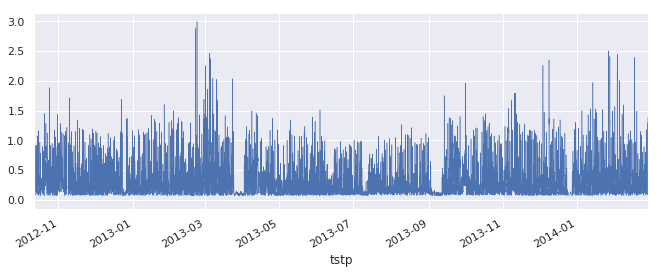

In [0]:
df2['energy(kWh/hh)'].plot(linewidth=0.5)

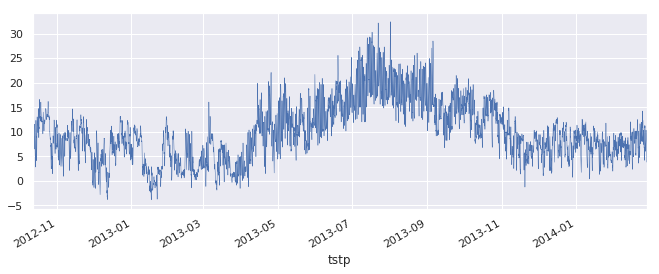

In [0]:
df2['temperature'].plot(linewidth=0.5)

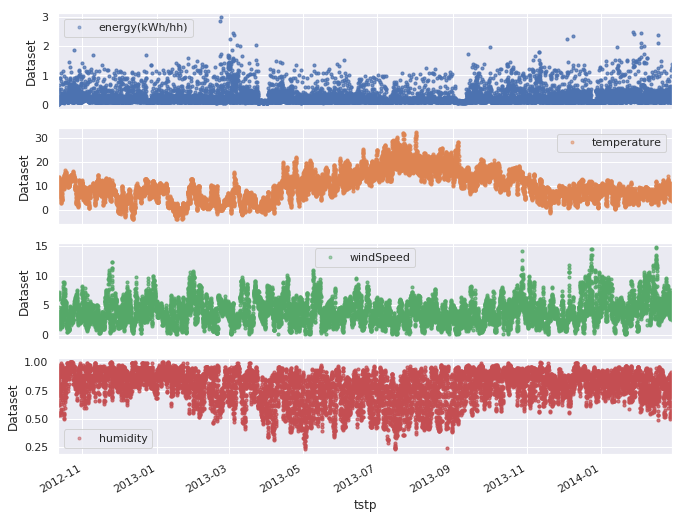

In [0]:
#Relación entre las distintas variables del dataset
cols_plot = ['energy(kWh/hh)', 'temperature', 'windSpeed', 'humidity']
axes = df2[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Dataset')

Text(0, 0.5, 'Daily Consumption (kWh/hh)')

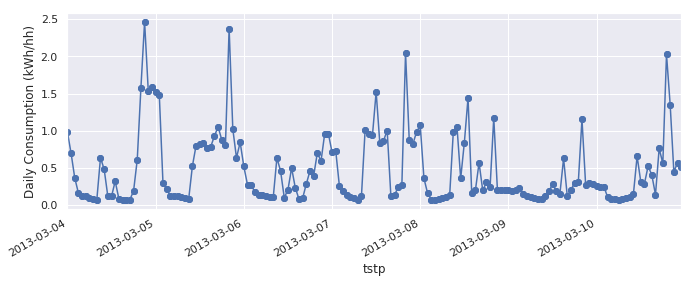

In [0]:
#Comportamiento del consumo energético de una casa durante una semana
ax = df2.loc['2013-03-04':'2013-03-10', 'energy(kWh/hh)'].plot(marker='o', linestyle='-')
ax.set_ylabel('Daily Consumption (kWh/hh)')

Text(0, 0.5, 'Daily Consumption (kWh/hh)')

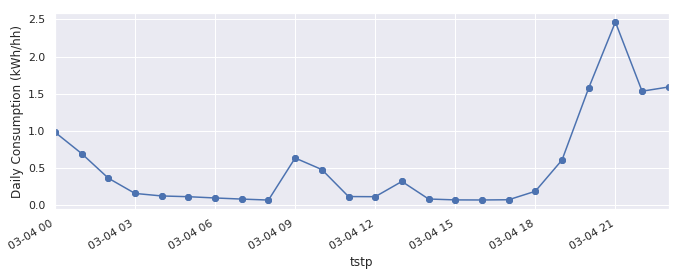

In [0]:
#Comportamiento del consumo energético de la casa seleccionada durante un lunes
ax = df2.loc['2013-03-04', 'energy(kWh/hh)'].plot(marker='o', linestyle='-')
ax.set_ylabel('Daily Consumption (kWh/hh)')

Text(0, 0.5, 'Daily Consumption (kWh/hh)')

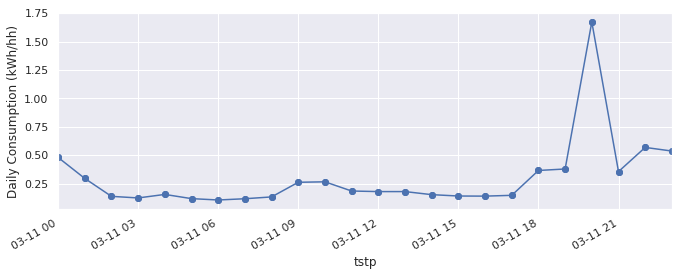

In [0]:
#Comportamiento del consumo energético de la casa seleccionada durante el proximo lunes
ax = df2.loc['2013-03-11', 'energy(kWh/hh)'].plot(marker='o', linestyle='-')
ax.set_ylabel('Daily Consumption (kWh/hh)')

In [0]:
df3=df2.copy()

In [0]:
df3.head()

,energy(kWh/hh),temperature,windSpeed,humidity
tstp,,,,
2012-10-12 01:00:00,0.0,13.09,6.77,0.89
2012-10-12 02:00:00,0.0,12.54,6.46,0.86
2012-10-12 03:00:00,0.0,11.94,6.37,0.84
2012-10-12 04:00:00,0.0,11.47,6.63,0.86
2012-10-12 05:00:00,0.0,10.87,6.55,0.86


In [0]:
# Add columns with year, month, and weekday name

df3['Year'] = df3.index.year
df3['Month'] = df3.index.month
df3['Weekday Name'] = df3.index.weekday_name

In [0]:
df3.head()

,energy(kWh/hh),temperature,windSpeed,humidity,Year,Month,Weekday Name
tstp,,,,,,,
2012-10-12 01:00:00,0.0,13.09,6.77,0.89,2012,10,Friday
2012-10-12 02:00:00,0.0,12.54,6.46,0.86,2012,10,Friday
2012-10-12 03:00:00,0.0,11.94,6.37,0.84,2012,10,Friday
2012-10-12 04:00:00,0.0,11.47,6.63,0.86,2012,10,Friday
2012-10-12 05:00:00,0.0,10.87,6.55,0.86,2012,10,Friday


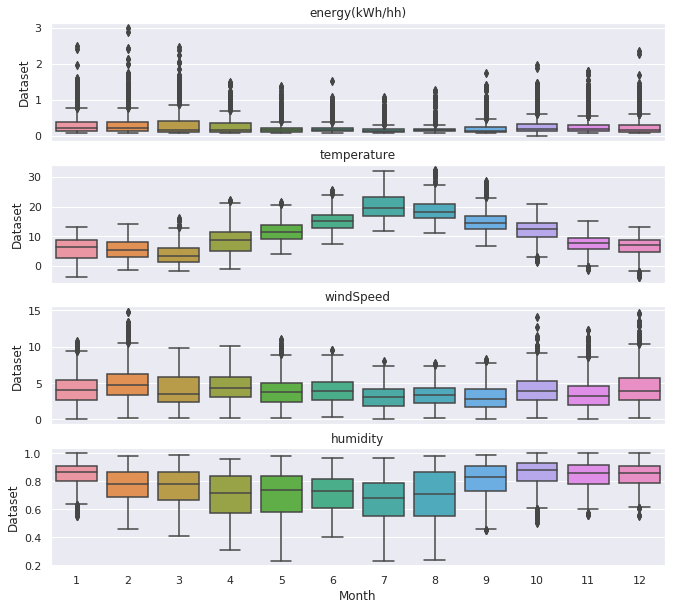

In [0]:
#Comportamiento de las variables del dataset dado los meses 
fig, axes = plt.subplots(4, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['energy(kWh/hh)', 'temperature', 'windSpeed', 'humidity'], axes):
    sns.boxplot(data=df3, x='Month', y=name, ax=ax)
    ax.set_ylabel('Dataset')
    ax.set_title(name)
# Remove the automatic x-axis label from all but the bottom subplot
    if ax != axes[-1]:
     ax.set_xlabel('')

In [0]:
#LSTM Multivariable Consumo Energético de una casa dado los datos de clima

In [0]:

df2 = pd.read_csv('gdrive/My Drive/Colab Notebooks/Proyecto/halfhourly_dataset/casa2.csv', parse_dates=['tstp'], index_col="tstp")

In [2]:
df2 = pd.read_csv('casa2.csv', parse_dates=['tstp'], index_col="tstp")

In [3]:
df2[22:27]

,energy(kWh/hh),temperature,windSpeed,humidity
tstp,,,,
2012-10-13 00:00:00,0.263,8.78,2.28,0.84
2012-10-13 01:00:00,0.275,8.27,1.81,0.87
2012-10-13 02:00:00,0.211,7.87,1.95,0.89
2012-10-13 03:00:00,0.161,7.89,1.83,0.93
2012-10-13 04:00:00,0.167,7.74,1.38,0.90


In [0]:
len(df2)

24136

In [0]:
''' Dividiendo el dataset en training y test '''
dataset = df2.values
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

16895 7241


In [0]:
train[0]

array([ 0.  , 13.09,  6.77,  0.89])

In [31]:
'''Funcion para crear tramas de tiempo con look backs '''
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [0]:
''' Creando tramas de tiempo con look backs '''
look_back = 20
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

16875
7221


In [0]:
trainX.shape

(16875, 20, 4)

In [0]:
''' Re-shaping de los datos según los requisitos del modelo'''
trainX = np.reshape(trainX, (trainX.shape[0], 20, trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], 20, testX.shape[2]))

In [0]:
''' Ajuste de los datos en el modelo LSTM Deep Learning '''
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
#model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
history = model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=True)

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 100)               42000     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 101       
Total params: 42,101
Trainable params: 42,101
Non-trainable params: 0
_________________________________________________________________


In [0]:
''' Haciendo la predicción de los datos '''
yhat = model.predict(testX)
yhat[0:5]

array([[0.11342725],
       [0.09374037],
       [0.09891025],
       [0.09841844],
       [0.09084938]], dtype=float32)

In [0]:
yhat1= yhat[:,0]

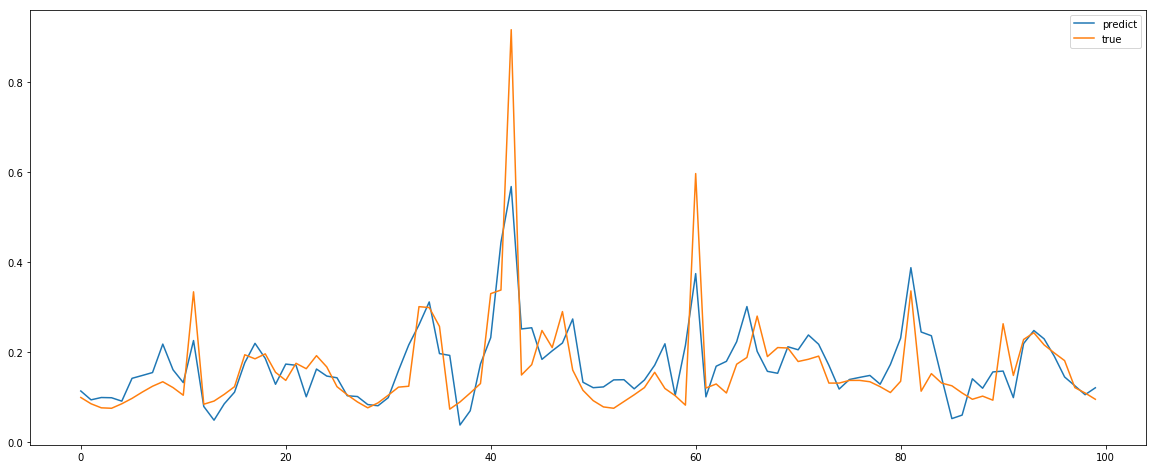

In [0]:
''' Plotting las primeras 100 entradas de la predicción '''
pyplot.figure(figsize=(20,8))
pyplot.plot(yhat1[0:100], label='predict')
pyplot.plot(testY[0:100], label='true')
pyplot.legend()
pyplot.show()

In [0]:
print("Mean squared error: %.3f" % mean_squared_error(testY, yhat1))

Mean squared error: 0.007


In [0]:
print("Root mean squared error: %.3f" % sqrt(mean_squared_error(testY, yhat1)))

Root mean squared error: 0.082


In [0]:
#El coeficiente de determinación es una medida estadística de qué tan bien las predicciones de regresión se aproximan a los puntos de datos reales
from sklearn.metrics import mean_squared_error, r2_score
print('Variance : %.3f' % r2_score(testY, yhat))

Variance : 0.890


In [0]:
#Probando con solo datos de clima y haciendo una predicción del consumo energético

In [0]:
df2.head()

,energy(kWh/hh),temperature,windSpeed,humidity
tstp,,,,
2012-10-12 01:00:00,0.0,13.09,6.77,0.89
2012-10-12 02:00:00,0.0,12.54,6.46,0.86
2012-10-12 03:00:00,0.0,11.94,6.37,0.84
2012-10-12 04:00:00,0.0,11.47,6.63,0.86
2012-10-12 05:00:00,0.0,10.87,6.55,0.86


In [0]:
df2.dtypes

energy(kWh/hh)    float64
temperature       float64
windSpeed         float64
humidity          float64
dtype: object

In [0]:
''' Dividiendo el dataset en training y test '''
dataset = df2.values
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

16895 7241


In [7]:
'''Funcion para crear tramas de tiempo con look backs '''
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 1:4]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [0]:
''' Creando tramas de tiempo con look backs'''
look_back = 20
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

16875
7221


In [0]:
trainX[0]

array([[13.09,  6.77,  0.89],
       [12.54,  6.46,  0.86],
       [11.94,  6.37,  0.84],
       [11.47,  6.63,  0.86],
       [10.87,  6.55,  0.86],
       [10.37,  6.11,  0.89],
       [10.39,  6.71,  0.87],
       [10.29,  6.59,  0.83],
       [10.94,  6.75,  0.76],
       [12.32,  7.15,  0.64],
       [13.86,  6.92,  0.53],
       [13.99,  7.  ,  0.53],
       [13.52,  6.63,  0.55],
       [12.69,  6.5 ,  0.62],
       [12.46,  5.98,  0.55],
       [11.31,  4.71,  0.62],
       [10.39,  3.7 ,  0.7 ],
       [ 9.38,  3.2 ,  0.75],
       [ 8.93,  3.12,  0.78],
       [ 8.93,  2.15,  0.78]])

In [0]:
trainY[0]

0.27

In [0]:
''' Re-shaping de los datos según los requisitos del modelo'''
trainX = np.reshape(trainX, (trainX.shape[0], 20, trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], 20, testX.shape[2]))

W0705 17:27:46.903688 140107020904320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0705 17:27:46.982258 140107020904320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0705 17:27:47.003438 140107020904320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0705 17:27:47.290713 140107020904320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0705 17:27:47.515556 140107020904320 deprecation.py:323

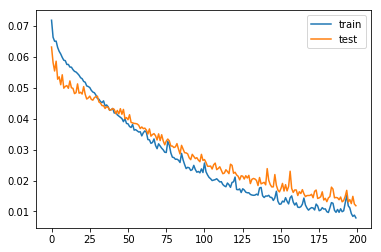

In [0]:
''' Ajuste de los datos en el modelo LSTM Deep Learning '''
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
#model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
history = model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=True)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               41600     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 41,701
Trainable params: 41,701
Non-trainable params: 0
_________________________________________________________________


In [0]:
''' Haciendo la predicción de los datos '''
yhat = model.predict(testX)
yhat[0:5]

array([[0.0115067 ],
       [0.0664138 ],
       [0.01942026],
       [0.04446337],
       [0.08021378]], dtype=float32)

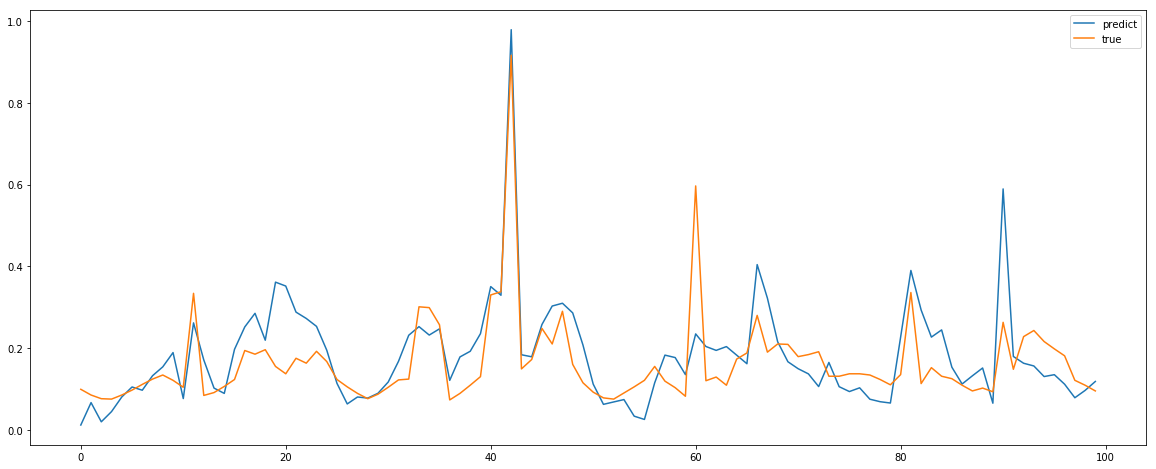

In [0]:
''' Plotting las primeras 100 entradas de la predicción '''
pyplot.figure(figsize=(20,8))
pyplot.plot(yhat[0:100], label='predict')
pyplot.plot(testY[0:100], label='true')
pyplot.legend()
pyplot.show()

In [0]:
print("Mean squared error: %.3f" % mean_squared_error(testY, yhat))

Mean squared error: 0.012


In [0]:
print("Root mean squared error: %.3f" % sqrt(mean_squared_error(testY, yhat)))

Root mean squared error: 0.109


In [0]:
from sklearn.metrics import mean_squared_error, r2_score
print('Variance : %.3f' % r2_score(testY, yhat))

Variance : 0.808


In [0]:
#Probando con Diferentes Tipos de LSTM

In [4]:
df2.head()

,energy(kWh/hh),temperature,windSpeed,humidity
tstp,,,,
2012-10-12 01:00:00,0.0,13.09,6.77,0.89
2012-10-12 02:00:00,0.0,12.54,6.46,0.86
2012-10-12 03:00:00,0.0,11.94,6.37,0.84
2012-10-12 04:00:00,0.0,11.47,6.63,0.86
2012-10-12 05:00:00,0.0,10.87,6.55,0.86


In [0]:
#Stacked LSTM
#https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
#Multiple hidden LSTM layers can be stacked one on top of another in what is referred to as a Stacked LSTM model.

In [78]:
''' Dividiendo el dataset en training y test '''
dataset = df2.values
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train1, test1 = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train1), len(test1))

16895 7241


In [79]:
''' Creando tramas de tiempo con look backs '''
look_back = 20
trainX1, trainY1 = create_dataset(train1, look_back)
testX1, testY1 = create_dataset(test1, look_back)

16875
7221


In [80]:
''' Re-shaping de los datos según los requisitos del modelo '''
trainX1 = np.reshape(trainX1, (trainX1.shape[0], 20, trainX1.shape[2]))
testX1 = np.reshape(testX1, (testX1.shape[0], 20, testX1.shape[2]))

In [81]:
trainX1.shape

(16875, 20, 4)

Train on 16875 samples, validate on 7221 samples
Epoch 1/200
 - 5s - loss: 0.3177 - val_loss: 0.0693
Epoch 2/200
 - 4s - loss: 0.0684 - val_loss: 0.0604
Epoch 3/200
 - 4s - loss: 0.0635 - val_loss: 0.0571
Epoch 4/200
 - 4s - loss: 0.0573 - val_loss: 0.0488
Epoch 5/200
 - 5s - loss: 0.0535 - val_loss: 0.0494
Epoch 6/200
 - 4s - loss: 0.0529 - val_loss: 0.0466
Epoch 7/200
 - 5s - loss: 0.0522 - val_loss: 0.0443
Epoch 8/200
 - 4s - loss: 0.0515 - val_loss: 0.0447
Epoch 9/200
 - 4s - loss: 0.0512 - val_loss: 0.0528
Epoch 10/200
 - 4s - loss: 0.0510 - val_loss: 0.0428
Epoch 11/200
 - 4s - loss: 0.0501 - val_loss: 0.0455
Epoch 12/200
 - 4s - loss: 0.0501 - val_loss: 0.0441
Epoch 13/200
 - 4s - loss: 0.0504 - val_loss: 0.0451
Epoch 14/200
 - 4s - loss: 0.0495 - val_loss: 0.0421
Epoch 15/200
 - 4s - loss: 0.0499 - val_loss: 0.0424
Epoch 16/200
 - 4s - loss: 0.0495 - val_loss: 0.0451
Epoch 17/200
 - 4s - loss: 0.0493 - val_loss: 0.0444
Epoch 18/200
 - 4s - loss: 0.0492 - val_loss: 0.0439
Epoch 

Epoch 154/200
 - 4s - loss: 0.0092 - val_loss: 0.0153
Epoch 155/200
 - 4s - loss: 0.0112 - val_loss: 0.0134
Epoch 156/200
 - 4s - loss: 0.0093 - val_loss: 0.0123
Epoch 157/200
 - 4s - loss: 0.0087 - val_loss: 0.0127
Epoch 158/200
 - 4s - loss: 0.0088 - val_loss: 0.0127
Epoch 159/200
 - 4s - loss: 0.0088 - val_loss: 0.0121
Epoch 160/200
 - 4s - loss: 0.0095 - val_loss: 0.0121
Epoch 161/200
 - 4s - loss: 0.0084 - val_loss: 0.0117
Epoch 162/200
 - 4s - loss: 0.0081 - val_loss: 0.0120
Epoch 163/200
 - 4s - loss: 0.0087 - val_loss: 0.0119
Epoch 164/200
 - 4s - loss: 0.0088 - val_loss: 0.0127
Epoch 165/200
 - 5s - loss: 0.0088 - val_loss: 0.0116
Epoch 166/200
 - 4s - loss: 0.0082 - val_loss: 0.0123
Epoch 167/200
 - 4s - loss: 0.0085 - val_loss: 0.0168
Epoch 168/200
 - 5s - loss: 0.0094 - val_loss: 0.0114
Epoch 169/200
 - 4s - loss: 0.0077 - val_loss: 0.0101
Epoch 170/200
 - 4s - loss: 0.0075 - val_loss: 0.0106
Epoch 171/200
 - 4s - loss: 0.0073 - val_loss: 0.0100
Epoch 172/200
 - 5s - loss: 

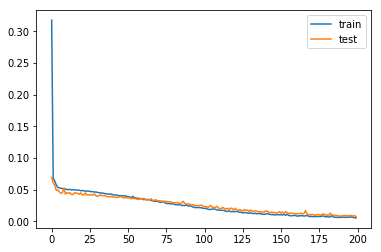

In [82]:
# define model
'''Ajuste de los datos en el modelo LSTM Deep Learning'''
model1 = Sequential()
model1.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(trainX1.shape[1], trainX1.shape[2])))
model1.add(LSTM(50, activation='relu'))
model1.add(Dense(1))
model1.compile(optimizer='adam', loss='mse')
history1 = model1.fit(trainX1, trainY1, epochs=200, batch_size=100, validation_data=(testX1, testY1), verbose=2, shuffle=True)
# plot history
pyplot.plot(history1.history['loss'], label='train')
pyplot.plot(history1.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [83]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 20, 50)            11000     
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 31,251
Trainable params: 31,251
Non-trainable params: 0
_________________________________________________________________


In [84]:
''' Haciendo la predicción de los datos '''
yhat1 = model1.predict(testX1)
yhat1[0:5]

array([[0.10786352],
       [0.12150732],
       [0.07507063],
       [0.09890001],
       [0.06675044]], dtype=float32)

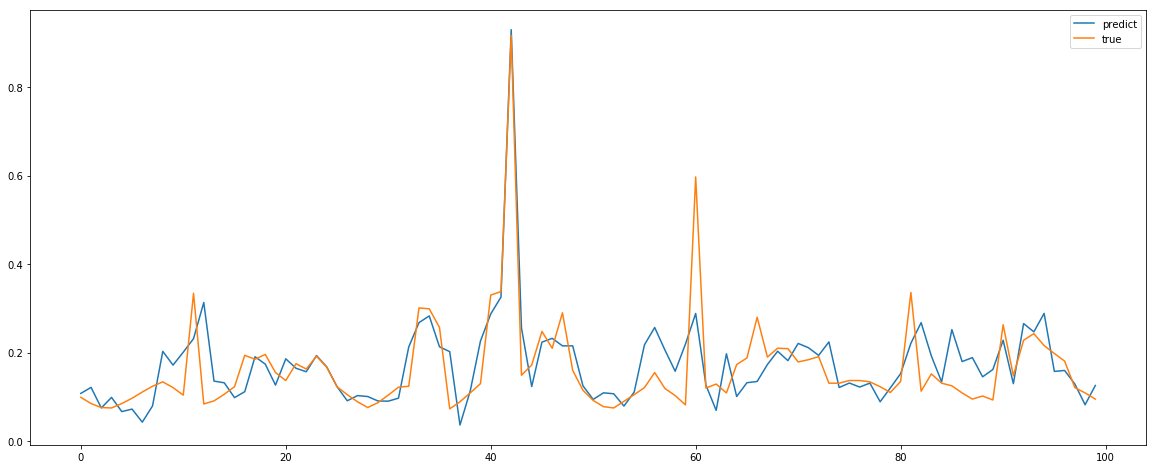

In [85]:
''' Plotting las primeras 100 entradas de la predicción '''
pyplot.figure(figsize=(20,8))
pyplot.plot(yhat1[0:100], label='predict')
pyplot.plot(testY1[0:100], label='true')
pyplot.legend()
pyplot.show()

In [86]:
print("Mean squared error: %.3f" % mean_squared_error(testY1, yhat1))

Mean squared error: 0.007


In [87]:
print("Root mean squared error: %.3f" % sqrt(mean_squared_error(testY1, yhat1)))

Root mean squared error: 0.085


In [88]:
from sklearn.metrics import mean_squared_error, r2_score
print('Variance : %.3f' % r2_score(testY1, yhat1))

Variance : 0.883


In [89]:
#Bidirectional LSTM
#On some sequence prediction problems, it can be beneficial to allow the LSTM model 
#to learn the input sequence both forward and backwards and concatenate both interpretations.

In [90]:
''' Dividiendo el dataset en training y test '''
dataset = df2.values
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train2, test2 = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train2), len(test2))

16895 7241


In [91]:
''' Creando tramas de tiempo con look backs '''
look_back = 20
trainX2, trainY2 = create_dataset(train2, look_back)
testX2, testY2 = create_dataset(test2, look_back)

16875
7221


In [92]:
''' Re-shaping de los datos según los requisitos del modelo '''
trainX2 = np.reshape(trainX2, (trainX2.shape[0], 20, trainX2.shape[2]))
testX2 = np.reshape(testX2, (testX2.shape[0], 20, testX2.shape[2]))

Train on 16875 samples, validate on 7221 samples
Epoch 1/200
 - 4s - loss: 0.3389 - val_loss: 0.0643
Epoch 2/200
 - 3s - loss: 0.0617 - val_loss: 0.0508
Epoch 3/200
 - 3s - loss: 0.0558 - val_loss: 0.0494
Epoch 4/200
 - 3s - loss: 0.0537 - val_loss: 0.0455
Epoch 5/200
 - 3s - loss: 0.0530 - val_loss: 0.0449
Epoch 6/200
 - 3s - loss: 0.0520 - val_loss: 0.0499
Epoch 7/200
 - 3s - loss: 0.0513 - val_loss: 0.0451
Epoch 8/200
 - 3s - loss: 0.0506 - val_loss: 0.0438
Epoch 9/200
 - 3s - loss: 0.0507 - val_loss: 0.0438
Epoch 10/200
 - 3s - loss: 0.0511 - val_loss: 0.0433
Epoch 11/200
 - 3s - loss: 0.0505 - val_loss: 0.0466
Epoch 12/200
 - 3s - loss: 0.0500 - val_loss: 0.0438
Epoch 13/200
 - 3s - loss: 0.0499 - val_loss: 0.0428
Epoch 14/200
 - 3s - loss: 0.0502 - val_loss: 0.0429
Epoch 15/200
 - 3s - loss: 0.0497 - val_loss: 0.0462
Epoch 16/200
 - 3s - loss: 0.0495 - val_loss: 0.0423
Epoch 17/200
 - 3s - loss: 0.0499 - val_loss: 0.0427
Epoch 18/200
 - 3s - loss: 0.0493 - val_loss: 0.0436
Epoch 

Epoch 154/200
 - 3s - loss: 0.0184 - val_loss: 0.0221
Epoch 155/200
 - 3s - loss: 0.0199 - val_loss: 0.0223
Epoch 156/200
 - 3s - loss: 0.0207 - val_loss: 0.0230
Epoch 157/200
 - 3s - loss: 0.0195 - val_loss: 0.0226
Epoch 158/200
 - 3s - loss: 0.0181 - val_loss: 0.0239
Epoch 159/200
 - 3s - loss: 0.0188 - val_loss: 0.0252
Epoch 160/200
 - 3s - loss: 0.0189 - val_loss: 0.0225
Epoch 161/200
 - 3s - loss: 0.0191 - val_loss: 0.0231
Epoch 162/200
 - 3s - loss: 0.0179 - val_loss: 0.0234
Epoch 163/200
 - 3s - loss: 0.0198 - val_loss: 0.0236
Epoch 164/200
 - 3s - loss: 0.0188 - val_loss: 0.0222
Epoch 165/200
 - 3s - loss: 0.0176 - val_loss: 0.0221
Epoch 166/200
 - 3s - loss: 0.0174 - val_loss: 0.0214
Epoch 167/200
 - 3s - loss: 0.0170 - val_loss: 0.0227
Epoch 168/200
 - 3s - loss: 0.0178 - val_loss: 0.0216
Epoch 169/200
 - 3s - loss: 0.0171 - val_loss: 0.0205
Epoch 170/200
 - 4s - loss: 0.0166 - val_loss: 0.0210
Epoch 171/200
 - 4s - loss: 0.0164 - val_loss: 0.0211
Epoch 172/200
 - 4s - loss: 

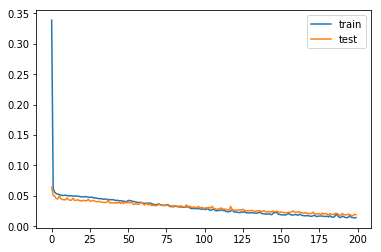

In [93]:
# define model
'''Ajuste de los datos en el modelo LSTM Deep Learning'''
model2 = Sequential()
model2.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(trainX2.shape[1], trainX2.shape[2])))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mse')
history2 = model2.fit(trainX2, trainY2, epochs=200, batch_size=100, validation_data=(testX2, testY2), verbose=2, shuffle=True)
# plot history
pyplot.plot(history2.history['loss'], label='train')
pyplot.plot(history2.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [94]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 100)               22000     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 22,101
Trainable params: 22,101
Non-trainable params: 0
_________________________________________________________________


In [96]:
''' Haciendo la predicción de los datos '''
yhat2 = model2.predict(testX2)
yhat2[0:5]

array([[ 0.03376172],
       [-0.0197985 ],
       [ 0.03721159],
       [ 0.03863615],
       [-0.01118474]], dtype=float32)

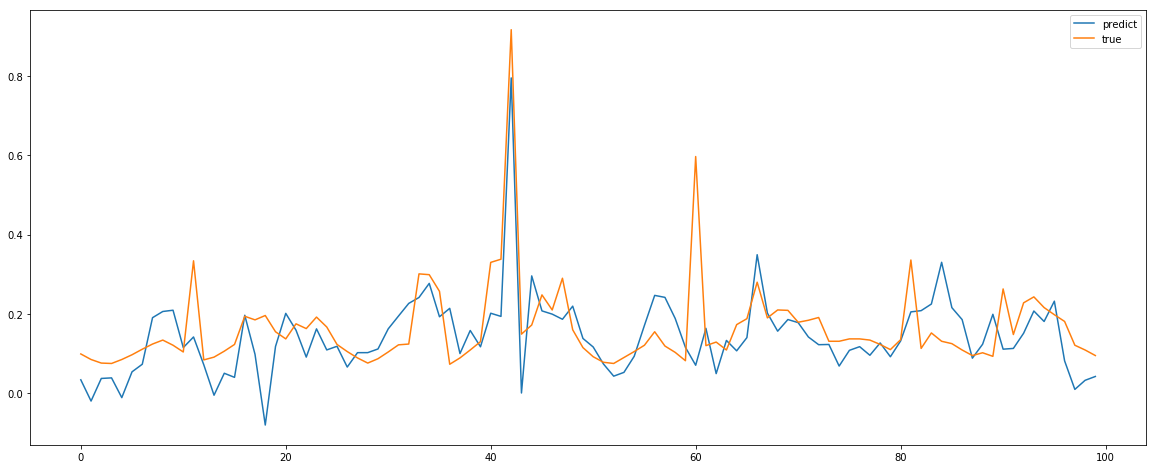

In [97]:
''' Plotting las primeras 100 entradas de la predicción '''
pyplot.figure(figsize=(20,8))
pyplot.plot(yhat2[0:100], label='predict')
pyplot.plot(testY2[0:100], label='true')
pyplot.legend()
pyplot.show()

In [98]:
print("Mean squared error: %.3f" % mean_squared_error(testY2, yhat2))

Mean squared error: 0.019


In [99]:
print("Root mean squared error: %.3f" % sqrt(mean_squared_error(testY2, yhat2)))

Root mean squared error: 0.138


In [100]:
from sklearn.metrics import mean_squared_error, r2_score
print('Variance : %.3f' % r2_score(testY2, yhat2))

Variance : 0.693


In [17]:
#CNN LSTM
#A convolutional neural network, or CNN for short, is a type of neural network developed
#for working with two-dimensional image data.

#The CNN can be very effective at automatically extracting and learning features from one-dimensional 
#sequence data such as univariate time series data.

#A CNN model can be used in a hybrid model with an LSTM backend where the CNN is used 
#to interpret subsequences of input that together are provided as a sequence to an LSTM model to interpret. This hybrid model is called a CNN-LSTM.

In [32]:
''' Dividiendo el dataset en training y test '''
dataset = df2.values
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train3, test3 = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train3), len(test3))

16895 7241


In [53]:
''' Creando tramas de tiempo con look backs '''
look_back = 20
trainX3, trainY3 = create_dataset(train3, look_back)
testX3, testY3 = create_dataset(test3, look_back)

16875
7221


In [54]:
''' Re-shaping de los datos según los requisitos del modelo '''
#trainX3 = np.reshape(trainX3, (trainX3.shape[0], 20, trainX3.shape[2]))
#testX3 = np.reshape(testX3, (testX3.shape[0], 20, testX3.shape[2]))

' Re-shaping data for model requirement '

In [55]:
trainX3.shape

(16875, 20, 4)

In [57]:
n_seq =4
n_steps = 5

trainX3 = np.reshape(trainX3, (trainX3.shape[0], n_seq, n_steps, trainX3.shape[2]))
testX3 = np.reshape(testX3, (testX3.shape[0], n_seq, n_steps, testX3.shape[2]))

Train on 16875 samples, validate on 7221 samples
Epoch 1/200
 - 2s - loss: 0.0840 - val_loss: 0.0581
Epoch 2/200
 - 1s - loss: 0.0636 - val_loss: 0.0542
Epoch 3/200
 - 1s - loss: 0.0621 - val_loss: 0.0531
Epoch 4/200
 - 1s - loss: 0.0599 - val_loss: 0.0510
Epoch 5/200
 - 1s - loss: 0.0588 - val_loss: 0.0498
Epoch 6/200
 - 1s - loss: 0.0575 - val_loss: 0.0497
Epoch 7/200
 - 1s - loss: 0.0569 - val_loss: 0.0512
Epoch 8/200
 - 1s - loss: 0.0563 - val_loss: 0.0479
Epoch 9/200
 - 1s - loss: 0.0558 - val_loss: 0.0496
Epoch 10/200
 - 1s - loss: 0.0545 - val_loss: 0.0497
Epoch 11/200
 - 1s - loss: 0.0540 - val_loss: 0.0487
Epoch 12/200
 - 1s - loss: 0.0535 - val_loss: 0.0474
Epoch 13/200
 - 1s - loss: 0.0534 - val_loss: 0.0474
Epoch 14/200
 - 1s - loss: 0.0525 - val_loss: 0.0459
Epoch 15/200
 - 1s - loss: 0.0523 - val_loss: 0.0463
Epoch 16/200
 - 1s - loss: 0.0522 - val_loss: 0.0478
Epoch 17/200
 - 1s - loss: 0.0514 - val_loss: 0.0465
Epoch 18/200
 - 1s - loss: 0.0506 - val_loss: 0.0474
Epoch 

Epoch 154/200
 - 1s - loss: 0.0162 - val_loss: 0.0211
Epoch 155/200
 - 1s - loss: 0.0153 - val_loss: 0.0216
Epoch 156/200
 - 1s - loss: 0.0156 - val_loss: 0.0212
Epoch 157/200
 - 1s - loss: 0.0156 - val_loss: 0.0215
Epoch 158/200
 - 1s - loss: 0.0155 - val_loss: 0.0220
Epoch 159/200
 - 1s - loss: 0.0159 - val_loss: 0.0203
Epoch 160/200
 - 1s - loss: 0.0152 - val_loss: 0.0212
Epoch 161/200
 - 1s - loss: 0.0153 - val_loss: 0.0209
Epoch 162/200
 - 1s - loss: 0.0160 - val_loss: 0.0223
Epoch 163/200
 - 1s - loss: 0.0154 - val_loss: 0.0205
Epoch 164/200
 - 1s - loss: 0.0154 - val_loss: 0.0212
Epoch 165/200
 - 1s - loss: 0.0153 - val_loss: 0.0206
Epoch 166/200
 - 1s - loss: 0.0147 - val_loss: 0.0203
Epoch 167/200
 - 1s - loss: 0.0148 - val_loss: 0.0201
Epoch 168/200
 - 1s - loss: 0.0145 - val_loss: 0.0199
Epoch 169/200
 - 1s - loss: 0.0146 - val_loss: 0.0205
Epoch 170/200
 - 1s - loss: 0.0147 - val_loss: 0.0197
Epoch 171/200
 - 1s - loss: 0.0144 - val_loss: 0.0225
Epoch 172/200
 - 1s - loss: 

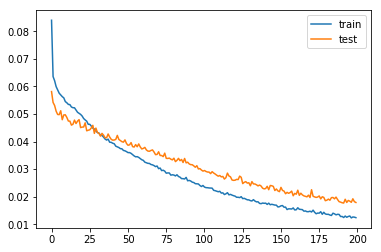

In [59]:
# define model
'''Ajuste de los datos en el modelo LSTM Deep Learning'''
model3 = Sequential()
model3.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, trainX3.shape[2], trainX3.shape[3])))
model3.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model3.add(TimeDistributed(Flatten()))
model3.add(LSTM(50, activation='relu'))
model3.add(Dense(1))
model3.compile(optimizer='adam', loss='mse')
history3 = model3.fit(trainX3, trainY3, epochs=200, batch_size=100, validation_data=(testX3, testY3), verbose=2, shuffle=True)
# plot history
pyplot.plot(history3.history['loss'], label='train')
pyplot.plot(history3.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [60]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_7 (TimeDist (None, None, 5, 64)       320       
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 2, 64)       0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, None, 128)         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 36,171
Trainable params: 36,171
Non-trainable params: 0
_________________________________________________________________


In [61]:
''' Haciendo la predicción de los datos '''
yhat3 = model3.predict(testX3)
yhat3[0:5]

array([[0.16586801],
       [0.12904085],
       [0.10992533],
       [0.10675322],
       [0.0339237 ]], dtype=float32)

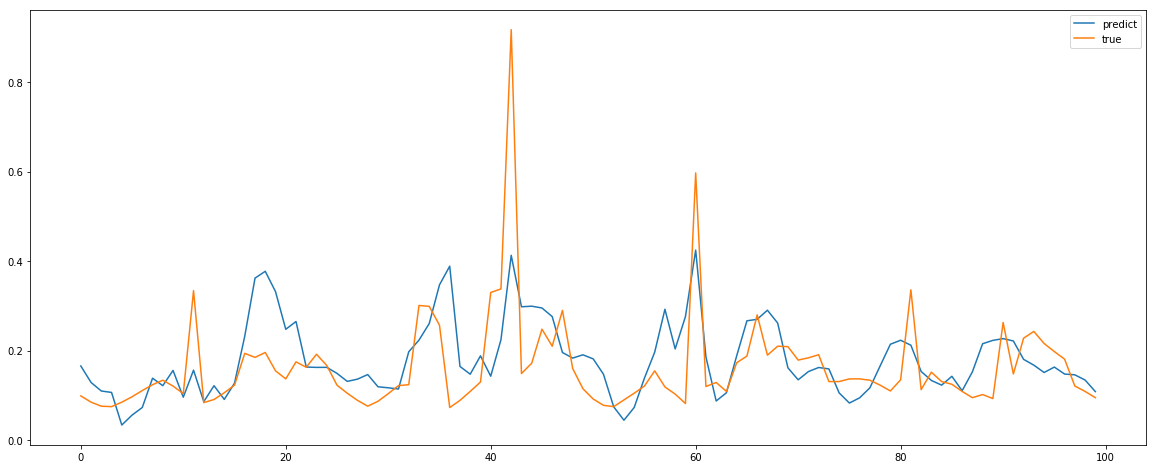

In [102]:
''' Plotting las primeras 100 entradas de la predicción '''
pyplot.figure(figsize=(20,8))
pyplot.plot(yhat3[0:100], label='predict')
pyplot.plot(testY3[0:100], label='true')
pyplot.legend()
pyplot.show()

In [63]:
print("Mean squared error: %.3f" % mean_squared_error(testY3, yhat3))

Mean squared error: 0.018


In [64]:
print("Root mean squared error: %.3f" % sqrt(mean_squared_error(testY3, yhat3)))

Root mean squared error: 0.134


In [65]:
from sklearn.metrics import mean_squared_error, r2_score
print('Variance : %.3f' % r2_score(testY3, yhat3))

Variance : 0.709


In [0]:
#ConvLSTM
#A type of LSTM related to the CNN-LSTM is the ConvLSTM, where the convolutional
#reading of input is built directly into each LSTM unit.

In [66]:
''' Dividiendo el dataset en training y test '''
dataset = df2.values
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train4, test4 = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train4), len(test4))

16895 7241


In [67]:
''' Creando tramas de tiempo con look backs '''
look_back = 20
trainX4, trainY4 = create_dataset(train4, look_back)
testX4, testY4 = create_dataset(test4, look_back)

16875
7221


In [68]:
trainX4.shape

(16875, 20, 4)

In [70]:
'''Re-shaping de los datos según los requisitos del modelo'''
n_seq =4
n_steps = 5

trainX4 = np.reshape(trainX4, (trainX4.shape[0], n_seq, 1 , n_steps, trainX4.shape[2]))
testX4 = np.reshape(testX4, (testX4.shape[0], n_seq, 1 , n_steps, testX4.shape[2]))

Train on 16875 samples, validate on 7221 samples
Epoch 1/200
 - 4s - loss: 0.0635 - val_loss: 0.0479
Epoch 2/200
 - 3s - loss: 0.0527 - val_loss: 0.0511
Epoch 3/200
 - 3s - loss: 0.0510 - val_loss: 0.0435
Epoch 4/200
 - 3s - loss: 0.0510 - val_loss: 0.0437
Epoch 5/200
 - 3s - loss: 0.0503 - val_loss: 0.0442
Epoch 6/200
 - 3s - loss: 0.0496 - val_loss: 0.0426
Epoch 7/200
 - 3s - loss: 0.0490 - val_loss: 0.0422
Epoch 8/200
 - 3s - loss: 0.0488 - val_loss: 0.0425
Epoch 9/200
 - 4s - loss: 0.0482 - val_loss: 0.0420
Epoch 10/200
 - 4s - loss: 0.0478 - val_loss: 0.0409
Epoch 11/200
 - 4s - loss: 0.0470 - val_loss: 0.0406
Epoch 12/200
 - 4s - loss: 0.0467 - val_loss: 0.0410
Epoch 13/200
 - 3s - loss: 0.0458 - val_loss: 0.0402
Epoch 14/200
 - 3s - loss: 0.0454 - val_loss: 0.0398
Epoch 15/200
 - 3s - loss: 0.0447 - val_loss: 0.0406
Epoch 16/200
 - 3s - loss: 0.0443 - val_loss: 0.0401
Epoch 17/200
 - 3s - loss: 0.0434 - val_loss: 0.0394
Epoch 18/200
 - 3s - loss: 0.0430 - val_loss: 0.0381
Epoch 

Epoch 154/200
 - 3s - loss: 0.0085 - val_loss: 0.0130
Epoch 155/200
 - 3s - loss: 0.0083 - val_loss: 0.0118
Epoch 156/200
 - 3s - loss: 0.0081 - val_loss: 0.0120
Epoch 157/200
 - 3s - loss: 0.0081 - val_loss: 0.0127
Epoch 158/200
 - 3s - loss: 0.0079 - val_loss: 0.0118
Epoch 159/200
 - 3s - loss: 0.0079 - val_loss: 0.0114
Epoch 160/200
 - 3s - loss: 0.0082 - val_loss: 0.0114
Epoch 161/200
 - 3s - loss: 0.0076 - val_loss: 0.0122
Epoch 162/200
 - 3s - loss: 0.0079 - val_loss: 0.0114
Epoch 163/200
 - 3s - loss: 0.0075 - val_loss: 0.0114
Epoch 164/200
 - 3s - loss: 0.0076 - val_loss: 0.0114
Epoch 165/200
 - 3s - loss: 0.0076 - val_loss: 0.0108
Epoch 166/200
 - 3s - loss: 0.0073 - val_loss: 0.0117
Epoch 167/200
 - 3s - loss: 0.0071 - val_loss: 0.0115
Epoch 168/200
 - 3s - loss: 0.0076 - val_loss: 0.0106
Epoch 169/200
 - 3s - loss: 0.0073 - val_loss: 0.0111
Epoch 170/200
 - 3s - loss: 0.0075 - val_loss: 0.0108
Epoch 171/200
 - 3s - loss: 0.0072 - val_loss: 0.0108
Epoch 172/200
 - 3s - loss: 

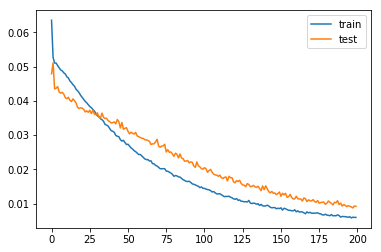

In [71]:
'''Ajuste de los datos en el modelo LSTM Deep Learning'''
model4 = Sequential()
model4.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(4, 1, trainX4.shape[3], trainX4.shape[4])))
model4.add(Flatten())
model4.add(Dense(1))
model4.compile(optimizer='adam', loss='mse')
history4 = model4.fit(trainX4, trainY4, epochs=200, batch_size=100, validation_data=(testX4, testY4), verbose=2, shuffle=True)
# plot history
pyplot.plot(history4.history['loss'], label='train')
pyplot.plot(history4.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [72]:
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 1, 4, 64)          35072     
_________________________________________________________________
flatten_4 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 35,329
Trainable params: 35,329
Non-trainable params: 0
_________________________________________________________________


In [73]:
''' Haciendo la predicción de los datos '''
yhat4 = model4.predict(testX4)
yhat4[0:5]

array([[0.14410715],
       [0.15175949],
       [0.05371612],
       [0.13054596],
       [0.0974493 ]], dtype=float32)

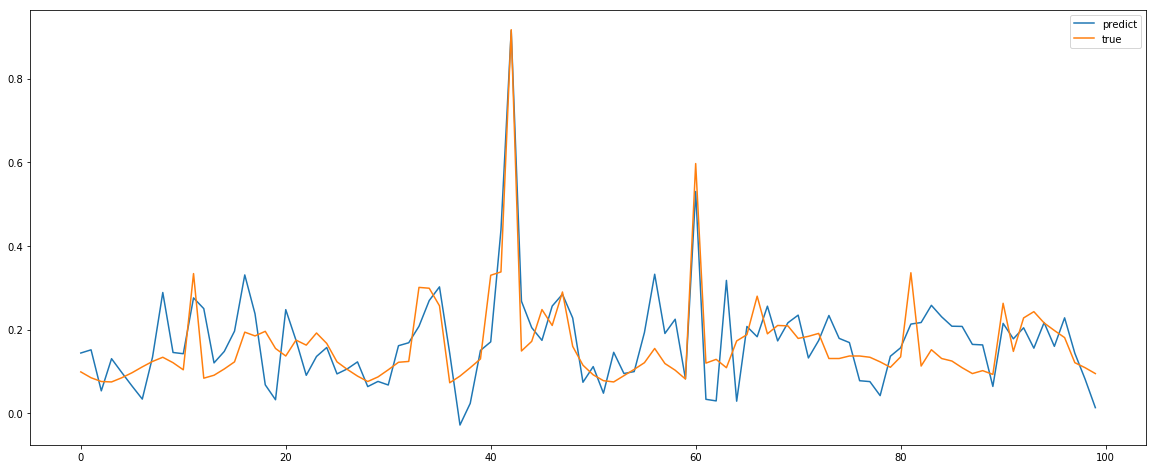

In [104]:
''' Plotting las primeras 100 entradas de la predicción  '''
pyplot.figure(figsize=(20,8))
pyplot.plot(yhat4[0:100], label='predict')
pyplot.plot(testY4[0:100], label='true')
pyplot.legend()
pyplot.show()

In [75]:
print("Mean squared error: %.3f" % mean_squared_error(testY4, yhat4))

Mean squared error: 0.009


In [76]:
print("Root mean squared error: %.3f" % sqrt(mean_squared_error(testY4, yhat4)))

Root mean squared error: 0.096


In [77]:
from sklearn.metrics import mean_squared_error, r2_score
print('Variance : %.3f' % r2_score(testY4, yhat4))

Variance : 0.850
